In [1]:
#User inputs
import os.path

#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#study boundary (optional)
#study_area_path=os.path.join(data_folder,'timor/boundaries.shp')
#area_sq=os.path.join(data_folder,'timor/timor_.shp')
#output folder
out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path_database=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=10000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)

In [2]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import io
import cdsapi # for copernicus function
import datetime # to have actual date
from osgeo import gdal, ogr, osr # in order to convert shp in raster
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D
import seaborn as sns

import sys 
sys.path.append("../0-Functions")

from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name

from Functions_Indicators import temporal_avg
from Functions_Indicators import temporal_max
from Functions_Indicators import df_stat_distr
from Functions_Indicators import number_day_above_threshold
from Functions_Indicators import filter_dataframe
from Functions_Indicators import changes_in_indicators
from Functions_Indicators import dataframe_n_day_event
from Functions_Indicators import dataframe_max_5_days_event
from Functions_Indicators import level_exposure
from Functions_Indicators import vulnerability
from Functions_Indicators import dataframe_threshold_coresponding_to_return_period_model
from Functions_Indicators import dataframe_return_period_coresponding_to_past_100year_event_model
from Functions_ImportData import add_year_month_season

from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
from Functions_ImportData import sensitivity
from Functions_ImportData import import_BC_NOAA_NEX_GDDP_CMIP6

from Graphs_functions import plot_lines
from Graphs_functions import trends_month

from Functions_likelihood import likelihood_accross_models
from Functions_likelihood import likelihood_accross_models_and_ssps

from Functions_likelihood import look_best_distr
from Functions_likelihood import range_likelihood

<a id='NEXGDDPCMIP6_Temperature'></a>
# NEX-GDDP-CMIP6 Temperature 

By comparing NEX GDDP CMIP6 data to observed data, we know that the models 'TAIESM1' and 'CMCC-CM2-SR5' do not comply to the observed data. We are taking them off the analysis.
A bias correction does not better the quality of the data. It follows oberved data enough. The data use below were not bias corrected a second time.

In [3]:
csv_path=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file'
locNames='_projectsMoz'

loc='Gorongosa_EIB' 
yr_past=np.array([1990, 2014]) # set periods
yr_future=np.array([2030,2050])
mod_excl=['CMCC-CM2-SR5','TaiESM1']

## TAS (all days - no aggregation)

In [4]:
df_tas_NEXGDDPCMIP6=import_treat_modeled_NEX_GDDP_CMIP6('tas','Celsius','day',1950,2100,csv_path,locNames) 

In [5]:
df_tas_NEXGDDPCMIP6_loc = filter_dataframe(df_tas_NEXGDDPCMIP6,[loc],mod_excl)#'TaiESM1','CMCC-CM2-SR5','NESM3'
#p=sns.lineplot(df_tas_NEXGDDPCMIP6_loc,x='Year',y='Daily Near-Surface Air Temperature °C',hue='Model')
#df_tas_NEXGDDPCMIP6_loc = filter_data(df_tas_NEXGDDPCMIP6,[loc],['TaiESM1','CMCC-CM2-SR5','NESM3','CanESM5'])#'TaiESM1','CMCC-CM2-SR5','NESM3'
#p=sns.lineplot(df_tas_NEXGDDPCMIP6_loc,x='Year',y='Daily Near-Surface Air Temperature °C',hue='Model')

In [6]:
#Past and future - seperated
df_tas_NEXGDDPCMIP6_loc_future=df_tas_NEXGDDPCMIP6_loc.reset_index()[df_tas_NEXGDDPCMIP6_loc.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Near-Surface Air Temperature °C','Model','Experiment']]
df_tas_NEXGDDPCMIP6_loc_past=df_tas_NEXGDDPCMIP6_loc.reset_index()[df_tas_NEXGDDPCMIP6_loc.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Near-Surface Air Temperature °C','Model','Experiment']]

In [7]:

df_tas_perc_future=df_tas_NEXGDDPCMIP6_loc_future.groupby(['Experiment','Model']).describe(percentiles=[.1,.5,.9])
df_tas_perc_past=df_tas_NEXGDDPCMIP6_loc_past.groupby(['Experiment','Model']).describe(percentiles=[.1, .5, .9])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=list(df_tas_NEXGDDPCMIP6_loc_future.Experiment.unique())
model_quant=['10%','50%','90%']
result=pd.DataFrame() #initialize dataframe
for s in scenarios: 
    df_future=df_tas_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_tas_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[.1,.5,.9])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

#Modelled historical percentiles
df_hist=df_tas_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
df_hist_perc=df_hist.describe(percentiles=[.1,.5,.9])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]

print(result)
result.to_excel("tas_scenarios_all.xlsx")  
df_hist_perc.to_excel("tas_hist_all.xlsx")

       index  p10 data  p50 data  p90 data Experiment
4  p10 model  0.810740  0.797092  0.828793     ssp245
5  p50 model  1.076703  0.986877  1.286258     ssp245
6  p90 model  1.494034  1.629465  1.908965     ssp245
4  p10 model  0.919394  1.035333  1.104027     ssp585
5  p50 model  1.307434  1.363892  1.655463     ssp585
6  p90 model  1.654495  1.809088  2.137809     ssp585
4  p10 model  0.621748  0.627393  0.660525     ssp126
5  p50 model  0.941669  1.017822  1.170422     ssp126
6  p90 model  1.469199  1.598639  1.912062     ssp126
4  p10 model  0.868591  1.011122  0.987390     ssp370
5  p50 model  1.070255  1.373817  1.494406     ssp370
6  p90 model  1.539932  1.703778  1.963217     ssp370


### cdf-curves

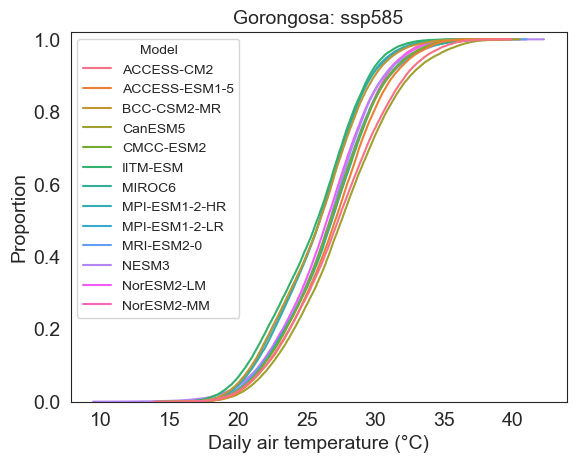

In [25]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
var='Daily mean '
scenario='ssp585' #'ssp126', ssp245', 'ssp370','ssp585''historical'
loc_= loc.replace('_','') # take off every - of project names
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_tas_scen=df_tas_NEXGDDPCMIP6_loc[df_tas_NEXGDDPCMIP6_loc['Experiment']==scenario]

f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_tas_scen['Daily Near-Surface Air Temperature °C'], hue=df_tas_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Daily air temperature (°C)')
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_+ ': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc+'_tas_'+scenario+ '.svg', bbox_inches='tight')

## TASMAX: all days - no aggregation

In [27]:
df_tasmax_NEXGDDPCMIP6 = import_treat_modeled_NEX_GDDP_CMIP6('tasmax','Celsius','day',1950,2100,csv_path,locNames) # maximum daily temperature

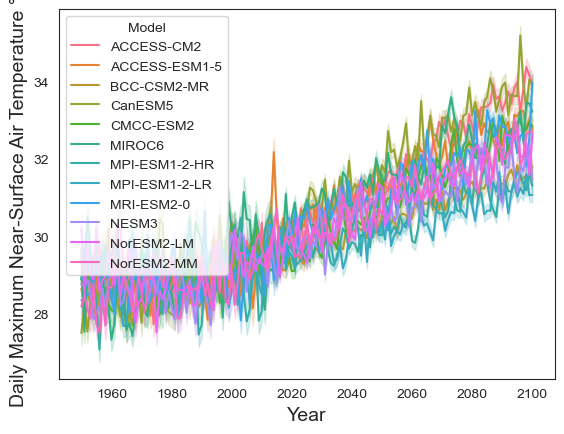

In [28]:
loc='Gorongosa_EIB' 
df_tasmax_NEXGDDPCMIP6_loc = filter_dataframe(df_tasmax_NEXGDDPCMIP6,[loc],['TaiESM1','CMCC-CM2-SR5'])#'TaiESM1','CMCC-CM2-SR5','NESM3'
p=sns.lineplot(df_tasmax_NEXGDDPCMIP6_loc,x='Year',y='Daily Maximum Near-Surface Air Temperature °C',hue='Model')

In [29]:
#Past and future - seperated
df_tasmax_NEXGDDPCMIP6_loc_future=df_tasmax_NEXGDDPCMIP6_loc.reset_index()[df_tasmax_NEXGDDPCMIP6_loc.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C','Model','Experiment','Year','Date']]
df_tasmax_NEXGDDPCMIP6_loc_past=df_tasmax_NEXGDDPCMIP6_loc.reset_index()[df_tasmax_NEXGDDPCMIP6_loc.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C','Model','Experiment','Year']]
#df_tasmax_NEXGDDPCMIP6_loc_future

In [35]:
# df_tasmax_perc_future=df_tasmax_NEXGDDPCMIP6_loc_future.groupby(['Experiment','Model']).describe(percentiles=[.1, .5, .9])
# df_tasmax_perc_future

In [30]:

df_tasmax_perc_future=df_tasmax_NEXGDDPCMIP6_loc_future.groupby(['Experiment','Model']).describe(percentiles=[.1,.5,.9])
df_tasmax_perc_past=df_tasmax_NEXGDDPCMIP6_loc_past.groupby(['Experiment','Model']).describe(percentiles=[.1, .5, .9])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=list(df_tasmax_NEXGDDPCMIP6_loc_future.Experiment.unique())
model_quant=['10%','50%','90%']
result=pd.DataFrame() #initialize dataframe
for s in scenarios: 
    df_future=df_tasmax_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_tasmax_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[.1,.5,.9])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

#Modelled historical percentiles
df_hist=df_tasmax_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
df_hist_perc=df_hist.describe(percentiles=[.1,.5,.9])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]

print(result)
result.to_excel("tasmax_scenarios_all.xlsx")  
df_hist_perc.to_excel("tasmax_hist_all.xlsx")

       index  p10 data  p50 data  p90 data Experiment
4  p10 model  0.621916  0.704218  0.775516     ssp245
5  p50 model  1.082700  1.219040  1.583533     ssp245
6  p90 model  1.519538  1.832045  2.285809     ssp245
4  p10 model  0.767721  1.010378  1.038211     ssp585
5  p50 model  1.248463  1.485924  1.790814     ssp585
6  p90 model  1.729702  1.898961  2.551270     ssp585
4  p10 model  0.437144  0.655345  0.763943     ssp126
5  p50 model  0.850533  0.934875  1.524631     ssp126
6  p90 model  1.509136  1.708510  2.248874     ssp126
4  p10 model  0.562274  0.981201  0.901416     ssp370
5  p50 model  1.093613  1.370178  1.628235     ssp370
6  p90 model  1.619791  1.835159  2.217401     ssp370


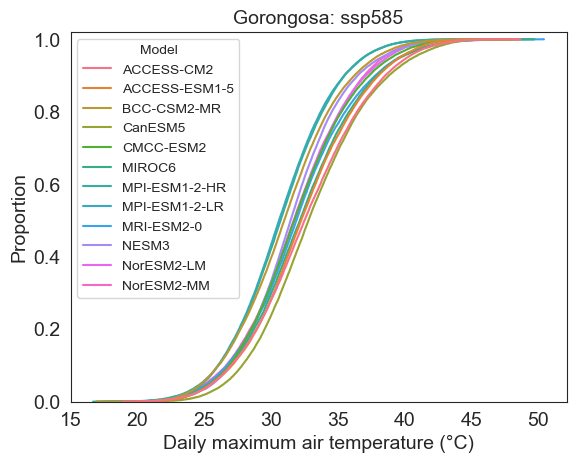

In [36]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
var='Daily max '
scenario='ssp585' #'ssp126', ssp245', 'ssp370','ssp585' 'historical'
loc_= loc.replace('_','') # take off every - of project names
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_tas_scen=df_tasmax_NEXGDDPCMIP6_loc[df_tasmax_NEXGDDPCMIP6_loc['Experiment']==scenario]

f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_tas_scen['Daily Maximum Near-Surface Air Temperature °C'], hue=df_tas_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Daily maximum air temperature (°C)')
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_+ ': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc+'_tasmax_'+scenario+ '.svg', bbox_inches='tight')

## TASMAX: yearly aggregation on 90th percentile

#### Taxmax- yearly aggregation 90th quantiles: All models treated together  - differentiating the scenario

In [27]:
df_tasmax_yrp90_loc = df_tasmax_NEXGDDPCMIP6_loc.groupby(['Name project','Experiment','Model','Year']).quantile([0.9])
df_tasmax_yrp90_loc=df_tasmax_yrp90_loc.reset_index()

In [28]:
#Past and future - seperated
df_tasmax_yrp90_loc_future=df_tasmax_yrp90_loc.reset_index()[df_tasmax_yrp90_loc.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C','Model','Experiment']]
df_tasmax_yrp90_loc_past=df_tasmax_yrp90_loc.reset_index()[df_tasmax_yrp90_loc.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Daily Maximum Near-Surface Air Temperature °C','Model','Experiment']]

In [38]:
#for testing 
# df_tasmax_yrp90_perc_future=df_tasmax_yrp90_loc_future.groupby(['Experiment','Model']).describe(percentiles=[.1, .5, .9])
# df_tasmax_yrp90_perc_future
#scenarios=list(df_tasmax_yrp90_perc_future.Experiment.unique())

In [39]:
#Finding percentiles of the maximum temperature aggregated per year 
df_tasmax_yrp90_perc_future=df_tasmax_yrp90_loc_future.groupby(['Experiment','Model']).describe(percentiles=[.1,.5,.9])
df_tasmax_yrp90_perc_past=df_tasmax_yrp90_loc_past.groupby(['Experiment','Model']).describe(percentiles=[.1, .5, .9])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=list(df_tasmax_yrp90_loc_future.Experiment.unique())
model_quant=['10%','50%','90%']
result=pd.DataFrame() #initialize dataframe
for s in scenarios: 
    df_future=df_tasmax_yrp90_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_tasmax_yrp90_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[.1,.5,.9])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

#Modelled historical percentiles
df_hist=df_tasmax_yrp90_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
df_hist_perc=df_hist.describe(percentiles=[.1,.5,.9])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]

print(result)
result.to_excel("tasmax_aggYr90p_scenarios.xlsx")  
df_hist_perc.to_excel("tasmax_aggrYr90p_hist.xlsx")

       index  p10 data  p50 data  p90 data Experiment
4  p10 model  0.773650  0.682879  0.616470     ssp126
5  p50 model  1.593737  1.490283  1.687717     ssp126
6  p90 model  2.354201  2.435942  2.344782     ssp126
4  p10 model  0.832662  0.673302  1.053846     ssp245
5  p50 model  1.685805  1.408182  1.557762     ssp245
6  p90 model  2.171323  2.484787  2.503068     ssp245
4  p10 model  1.247538  1.125793  0.596172     ssp370
5  p50 model  1.699052  1.623236  1.635162     ssp370
6  p90 model  2.515016  2.476117  2.479954     ssp370
4  p10 model  1.285833  1.155433  1.034122     ssp585
5  p50 model  1.831252  1.860593  2.076721     ssp585
6  p90 model  2.195465  2.823375  2.893617     ssp585


In [83]:
scenarios=list(df_tasmax_NEXGDDPCMIP6_loc_future.Experiment.unique())
perc='50%'
change_list=np.array([])
for s in scenarios:
    yr_tasmax_p90_future=df_tasmax_yrp90_loc_future[(df_tasmax_yrp90_loc_future['Experiment']==s)].describe(percentiles=[0.5,0.9]).T 
    yr_tasmax_p90_past=df_tasmax_yrp90_loc_past.describe(percentiles=[0.5]).T
    change=yr_tasmax_p90_future[perc]-yr_tasmax_p90_past[perc]
    print(s,': ', change)
print(s, ';', yr_tasmax_p90_past[perc])

ssp245 :  Daily Maximum Near-Surface Air Temperature °C    2.133383
Name: 50%, dtype: float64
ssp585 :  Daily Maximum Near-Surface Air Temperature °C    2.582712
Name: 50%, dtype: float64
ssp126 :  Daily Maximum Near-Surface Air Temperature °C    1.750745
Name: 50%, dtype: float64
ssp370 :  Daily Maximum Near-Surface Air Temperature °C    2.288263
Name: 50%, dtype: float64
ssp370 ; Daily Maximum Near-Surface Air Temperature °C    33.39993
Name: 50%, dtype: float64


#### Taxmax- yearly aggregation 90th quantiles: Models treated individually 
90th quantile found on all of the data 


In [106]:
models=list(df_tasmax_NEXGDDPCMIP6_loc.Model.unique())
scenarios=list(df_tasmax_NEXGDDPCMIP6_loc_future.Experiment.unique())

#df_yr_p90 = df_df_tasmax_NEXGDDPCMIP6_loc.groupby(['Name project','Experiment','Model','Year'])[[title_column]].quantile([0.9])

perc='50%'#10%, 50%, 90%
print('percentile=',perc)
change_list=np.array([])
past_list=np.array([])
for s in scenarios:
    i=scenarios.index(s)
    for m in models:
        #past skal ikke filtreres for scenario - der er kun historical
        df_perc_past=df_tasmax_yrp90_loc_past[df_tasmax_yrp90_loc_past['Model']==m].describe(percentiles=[.1, .5, .9]).T
        if i==0:    
            #df_perc_past=df_tas_NEXGDDPCMIP6_loc_past[df_tas_NEXGDDPCMIP6_loc_past['Model']==m].describe(percentiles=[.1, .5, .9]).T
            past=df_perc_past[perc] #runs every time but no need to 
            past_list=np.append(past_list,past)
        else: 
            pass
        df_perc_future=df_tasmax_yrp90_loc_future[(df_tasmax_yrp90_loc_future['Model']==m)&(df_tasmax_yrp90_loc_future['Experiment']==s)].describe(percentiles=[.1, .5, .9]).T 
        change=df_perc_future[perc]-df_perc_past[perc]
        #print(s,m,change)
        change_list=np.append(change_list,change)
    modelChange=[round(np.nanmin(change_list),2),round(np.nanmean(change_list),2),round(np.nanmax(change_list),2)]
    print(s, ':min, mean and max ',modelChange)
    change_list=np.array([])
past_perc=[round(np.nanmin(past_list),2),round(np.nanmean(past_list),2),round(np.nanmax(past_list),2)]
print('modelled historical: min, mean and max',past_perc)

percentile= 50%
ssp245 :min, mean and max  [1.23, 2.24, 3.22]
ssp585 :min, mean and max  [1.3, 2.73, 4.11]
ssp126 :min, mean and max  [1.09, 1.9, 2.81]
ssp370 :min, mean and max  [1.52, 2.34, 3.18]
modelled historical: min, mean and max [33.17, 33.38, 33.56]


#### Taxmax- yearly aggregation 90th quantiles: Models treated individually 
90th quantile found on each of the models 
##### THIS IS THE SAME AS IF 90th quantile is found for all of them at first - but does it make sense? 

In [107]:
## SORTING THE 90TH QUANTILE MODEL BY MODEL
models=list(df_tasmax_NEXGDDPCMIP6_loc.Model.unique())
scenarios=list(df_tasmax_NEXGDDPCMIP6_loc_future.Experiment.unique())

#df_yr_p90 = df_df_tasmax_NEXGDDPCMIP6_loc.groupby(['Name project','Experiment','Model','Year'])[[title_column]].quantile([0.9])

perc='50%'#10%, 50%, 90%
print('percentile=',perc)
change_list=np.array([])
past_list=np.array([])
for s in scenarios:
    i=scenarios.index(s)
    for m in models:
        #past skal ikke filtreres for scenario - der er kun historical
        df_past_mod=df_tasmax_NEXGDDPCMIP6_loc_past[df_tasmax_NEXGDDPCMIP6_loc_past['Model']==m]
        df_past_yr=df_past_mod.groupby(['Name project','Experiment','Year']).quantile([0.9])
        df_perc_past=df_past_yr.describe(percentiles=[0.1,0.5,0.9]).T
        if i==0:    
            #df_perc_past=df_tas_NEXGDDPCMIP6_loc_past[df_tas_NEXGDDPCMIP6_loc_past['Model']==m].describe(percentiles=[.1, .5, .9]).T            
            past=df_perc_past[perc] 
            past_list=np.append(past_list,past)
        else: 
            pass
        df_future_mod=df_tasmax_NEXGDDPCMIP6_loc_future[(df_tasmax_NEXGDDPCMIP6_loc_future['Model']==m) & (df_tasmax_NEXGDDPCMIP6_loc_future['Experiment']==s)]
        df_future_yr=df_future_mod.groupby(['Name project','Experiment','Year']).quantile([0.9]).reset_index()
        #df_perc_future=df_future_yr.describe(percentiles=[0.5]).T        
        df_perc_future=df_future_yr.describe(percentiles=[.1, .5, .9]).T 
        change=df_perc_future[perc]-df_perc_past[perc]
        #print(s,m,change)
        change_list=np.append(change_list,change)
    modelChange=[round(np.nanmin(change_list),2),round(np.nanmean(change_list),2),round(np.nanmax(change_list),2)]
    print(s, ':min, mean and max ',modelChange)
    change_list=np.array([])
past_perc=[round(np.nanmin(past_list),2),round(np.nanmean(past_list),2),round(np.nanmax(past_list),2)]
print('modelled historical: min, mean and max',past_perc)

percentile= 50%
ssp245 :min, mean and max  [1.23, 2.24, 3.22]
ssp585 :min, mean and max  [1.3, 2.73, 4.11]
ssp126 :min, mean and max  [1.09, 1.9, 2.81]
ssp370 :min, mean and max  [1.52, 2.34, 3.18]
modelled historical: min, mean and max [33.17, 33.38, 33.56]


In [100]:
df_future_yr=df_future_mod.groupby(['Name project','Experiment','Year']).quantile([0.9]).reset_index()
df_future_mod

,Name project,Daily Maximum Near-Surface Air Temperature °C,Model,Experiment,Year,Date
525588,Gorongosa_EIB,29.117828,NorESM2-MM,ssp245,2030,01-01-2030
525589,Gorongosa_EIB,31.735779,NorESM2-MM,ssp245,2030,02-01-2030
525590,Gorongosa_EIB,35.881226,NorESM2-MM,ssp245,2030,03-01-2030
525591,Gorongosa_EIB,34.181030,NorESM2-MM,ssp245,2030,04-01-2030
525592,Gorongosa_EIB,26.641510,NorESM2-MM,ssp245,2030,05-01-2030
...,...,...,...,...,...,...
1484349,Gorongosa_EIB,34.178009,NorESM2-MM,ssp370,2074,27-12-2074
1484350,Gorongosa_EIB,31.020020,NorESM2-MM,ssp370,2074,28-12-2074
1484351,Gorongosa_EIB,30.069855,NorESM2-MM,ssp370,2074,29-12-2074
1484352,Gorongosa_EIB,29.553467,NorESM2-MM,ssp370,2074,30-12-2074


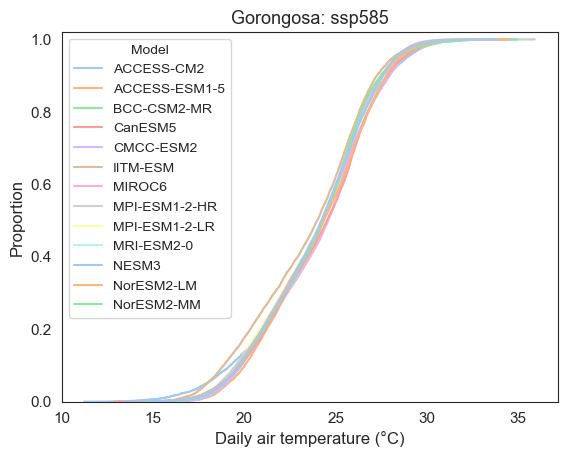

In [40]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
var='Daily mean '
scenario='ssp585' #'ssp126', ssp245', 'ssp370','ssp585'

loc_= loc.replace('_','') # take off every - of project names
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_tas_scen_future=df_tas_NEXGDDPCMIP6_loc_future[df_tas_NEXGDDPCMIP6_loc_future['Experiment']==scenario]
df_tas_scen_past=df_tas_NEXGDDPCMIP6_loc_past

f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_tas_scen_past['Daily Near-Surface Air Temperature °C'], hue=df_tas_scen_past['Model'],palette=('pastel'))
#sns.color_palette('pastel')
#ax = sns.ecdfplot(x=df_tas_scen_future['Daily Near-Surface Air Temperature °C'], hue=df_tas_scen_future['Model'])
#sns.color_palette('bright') How to change colors from the different plots???!! 
ax.grid(False)
sns.set_context( rc={"axes.titlesize":13,"axes.labelsize":12})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=11)
plt.xlabel('Daily air temperature (°C)')
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_+ ': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc+'_tas_'+scenario+ '.svg', bbox_inches='tight')

In [115]:
df_tas_scen_past=df_tas_NEXGDDPCMIP6_loc_future[df_tas_NEXGDDPCMIP6_loc_future['Experiment']==scenario]
df_tas_scen_past

,Name project,Daily Near-Surface Air Temperature °C,Model,Experiment
612151,Gorongosa_EIB,28.879303,ACCESS-CM2,ssp585
612152,Gorongosa_EIB,27.897919,ACCESS-CM2,ssp585
612153,Gorongosa_EIB,26.240295,ACCESS-CM2,ssp585
612154,Gorongosa_EIB,27.537323,ACCESS-CM2,ssp585
612155,Gorongosa_EIB,29.238983,ACCESS-CM2,ssp585
...,...,...,...,...
942692,Gorongosa_EIB,27.211884,NorESM2-MM,ssp585
942693,Gorongosa_EIB,29.096832,NorESM2-MM,ssp585
942694,Gorongosa_EIB,32.384918,NorESM2-MM,ssp585
942695,Gorongosa_EIB,32.064606,NorESM2-MM,ssp585


# Precipitation 

In [27]:

# import os
# import os.path
# #from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
# #from Functions_ImportData import import_BC_NOAA_NEX_GDDP_CMIP6
# #from Functions_ImportData import import_BC_Gorongosa_NEX_GDDP_CMIP6
# from Functions_ImportData import add_year_month_season

# from Potential_evapostranspiration_function import PET

def filter_data(df,loc,mod_excl): # Filter data by location, models, and time period
    df = df[df['Name project']==loc]
    df = df[~df['Model'].isin(mod_excl)]
    df=add_year_month_season(df,'Date')
    return df
#precipitation 
path_pr=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1950-2100\pr_1950-2100_projectsMoz.csv'
#tas: daily mean temperature


#READ PRECIPITATION 
df_pr=pd.read_csv(path_pr)
df_pr=filter_data(df_pr,loc,mod_excl)
df_pr_past=df_pr[df_pr['Year'].between(yr_past[0],yr_past[1])]
df_pr_future=df_pr[df_pr['Year'].between(yr_future[0],yr_future[1])]


In [90]:
# CHANGE ACCORDING TO PURPOSE 
loc='Gorongosa_EIB'
mod_excl=['NESM3','CMCC-CM2-SR5','TaiESM1']
yr_past=np.array([1990, 2014])
yr_future=np.array([2030,2050])
threshold_val=20 #threshold value to count days above 

In [91]:
df_pr_yrThreshold = df_pr[df_pr['Mean of the daily precipitation rate mm_per_day']>threshold_val].groupby(['Name project','Experiment','Model','Year']).count()
df_pr_yrThreshold_future=df_pr_yrThreshold.reset_index()[df_pr_yrThreshold.reset_index()['Year'].between(yr_future[0],yr_future[1])][['Name project','Mean of the daily precipitation rate mm_per_day','Model','Experiment']]
df_pr_yrThreshold_past=df_pr_yrThreshold.reset_index()[df_pr_yrThreshold.reset_index()['Year'].between(yr_past[0],yr_past[1])][['Name project','Mean of the daily precipitation rate mm_per_day','Model','Experiment']]
df_pr_yrThreshold_past['Mean of the daily precipitation rate mm_per_day'].mean()
df_pr_yrThreshold_future

,Name project,Mean of the daily precipitation rate mm_per_day,Model,Experiment
793,Gorongosa_EIB,11,ACCESS-CM2,ssp126
794,Gorongosa_EIB,12,ACCESS-CM2,ssp126
795,Gorongosa_EIB,12,ACCESS-CM2,ssp126
796,Gorongosa_EIB,9,ACCESS-CM2,ssp126
797,Gorongosa_EIB,18,ACCESS-CM2,ssp126
...,...,...,...,...
4839,Gorongosa_EIB,18,NorESM2-MM,ssp585
4840,Gorongosa_EIB,9,NorESM2-MM,ssp585
4841,Gorongosa_EIB,17,NorESM2-MM,ssp585
4842,Gorongosa_EIB,7,NorESM2-MM,ssp585


In [92]:
#Finding percentiles of the maximum temperature aggregated per year 
df_perc_future=df_pr_yrThreshold_future.groupby(['Experiment','Model']).describe(percentiles=[.1,.5,.9])
df_perc_past=df_pr_yrThreshold_past.groupby(['Experiment','Model']).describe(percentiles=[.1, .5, .9])

#Future scenarios quantiles: 
idx=pd.IndexSlice
scenarios=['ssp126', 'ssp245', 'ssp370', 'ssp585']
model_quant=['10%','50%','90%']
result=pd.DataFrame() #initialize dataframe
df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
df_hist.columns=df_hist.columns.droplevel(0)
df_hist=df_hist[model_quant]
dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
df_hist.rename(columns=dict,inplace=True)
df_hist_perc=df_hist.describe(percentiles=[.1,.5,.9])
dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
df_hist_perc.rename(index=dict,inplace=True)
df_hist_perc=df_hist_perc.reset_index()
df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]
df_hist_perc['Experiment']='historical'
result=pd.concat([result,df_hist_perc])
for s in scenarios: 
    df_future=df_perc_future.loc[idx[s,:],:].droplevel('Experiment')
    df_past=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
    diff=(df_future-df_past)
    diff.columns=diff.columns.droplevel(0) # remove header to refer to temperature
    diff=diff[model_quant]
    dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
    diff.rename(columns=dict,inplace=True)
    diff_perc=diff.describe(percentiles=[.1,.5,.9])
    dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
    diff_perc.rename(index=dict,inplace=True)
    diff_perc=diff_perc.reset_index()
    diff_perc=diff_perc[diff_perc['index'].isin(['p10 model','p50 model','p90 model'])]
    diff_perc['Experiment']=s
    result=pd.concat([result,diff_perc])

# #Modelled historical percentiles
# df_hist=df_perc_past.loc[idx['historical',:],:].droplevel('Experiment')
# df_hist.columns=df_hist.columns.droplevel(0)
# df_hist=df_hist[model_quant]
# dict = {'10%': 'p10 data','50%': 'p50 data','90%': 'p90 data'}
# df_hist.rename(columns=dict,inplace=True)
# df_hist_perc=df_hist.describe(percentiles=[.1,.5,.9])
# dict = {'10%': 'p10 model','50%': 'p50 model','90%': 'p90 model'}
# df_hist_perc.rename(index=dict,inplace=True)
# df_hist_perc=df_hist_perc.reset_index()
# df_hist_perc=df_hist_perc[df_hist_perc['index'].isin(['p10 model','p50 model','p90 model'])]

print(result)
result.to_excel("precAbove20mm.xlsx")  
#print(df_hist_perc)
#df_hist_perc.to_excel("precAbove5mm_hist.xlsx")

       index  p10 data  p50 data  p90 data  Experiment
4  p10 model      5.14      10.1     16.64  historical
5  p50 model      7.40      13.0     18.70  historical
6  p90 model      9.90      16.0     22.56  historical
4  p10 model     -2.80      -3.8     -3.52      ssp126
5  p50 model      0.60       0.0      1.00      ssp126
6  p90 model      1.90       2.8      3.42      ssp126
4  p10 model     -1.94      -2.9     -2.32      ssp245
5  p50 model      0.00      -0.5     -0.50      ssp245
6  p90 model      2.18       3.0      5.36      ssp245
4  p10 model     -2.80      -3.9     -4.04      ssp370
5  p50 model     -0.20      -1.0      0.80      ssp370
6  p90 model      1.56       1.9      3.92      ssp370
4  p10 model     -2.90      -2.9     -3.48      ssp585
5  p50 model     -0.20      -1.0     -0.40      ssp585
6  p90 model      1.60       1.9      2.90      ssp585


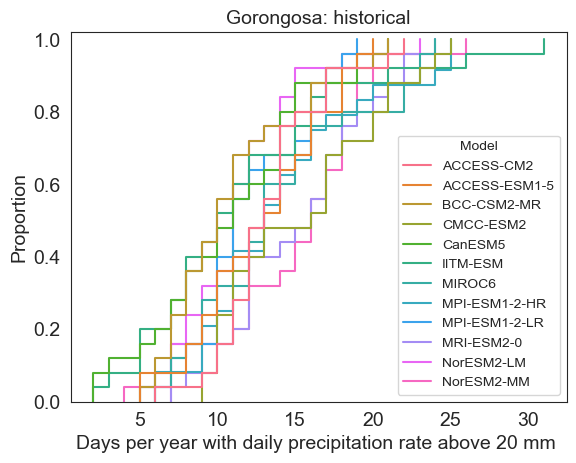

In [98]:
#USE THIS ONE
# CDF-curves for Models with different scenarios 
var='20 mm '
scenario='historical' #'ssp126', ssp245', 'ssp370','ssp585' 'historical'
loc_= loc.replace('_','') # take off every - of project names
loc_=loc_.replace('WTP','')
loc_=loc_.replace('EIB','')

df_tas_scen=df_pr_yrThreshold_past[df_pr_yrThreshold_past['Experiment']==scenario]
#df_tas_scen=df_pr_yrThreshold_future[df_pr_yrThreshold_future['Experiment']==scenario]
f, ax = plt.subplots()
#for m in models:
ax = sns.ecdfplot(x=df_tas_scen['Mean of the daily precipitation rate mm_per_day'], hue=df_tas_scen['Model'])
ax.grid(False)
sns.set_context( rc={"axes.titlesize":14,"axes.labelsize":14})  
ylim_min=0#df[y_axis].min()
ylim_max=1.02#df[y_axis].max()
ax.set_ylim(ylim_min,ylim_max)
ax.tick_params(labelsize=14)
plt.xlabel('Days per year with daily precipitation rate above'+' '+ var)
sns.set_style("white")
sns.set_style(rc = {'axes.facecolor': 'white'})
title=loc_+ ': ' + scenario
plt.title(title)
f.tight_layout#
f.savefig(loc+'_precAbove'+var+scenario+ '.svg', bbox_inches='tight')